In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import ASSETS, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = SAM("sam2_s.pt")



image 1/1 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 1024x1024 5933.9ms
Speed: 11.5ms preprocess, 5933.9ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)



image 1/1 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 1024x1024 4897.5ms
Speed: 19.3ms preprocess, 4897.5ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)


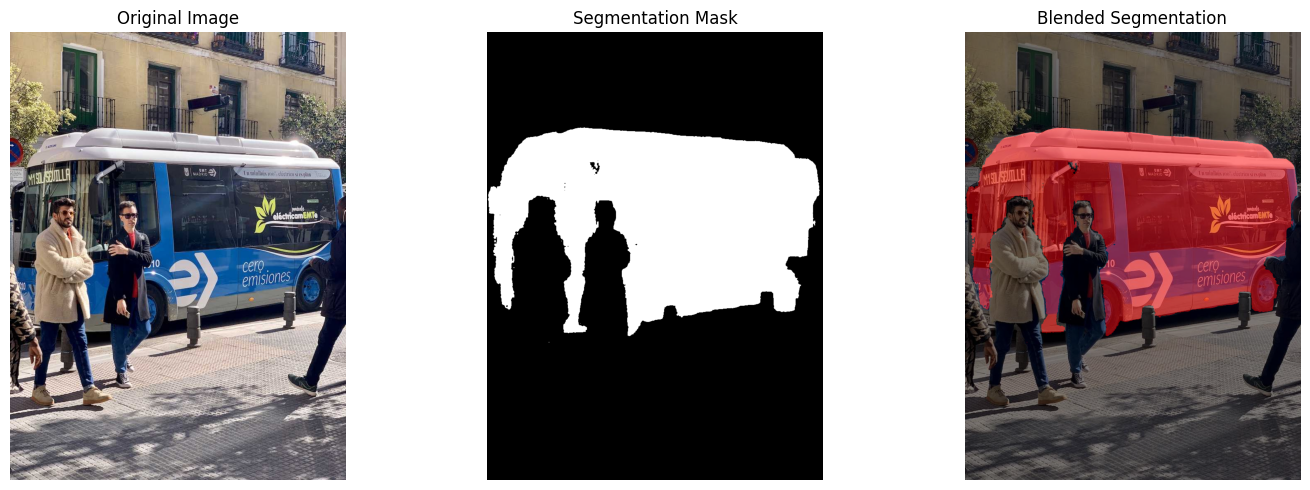

In [ ]:
# Segment with multiple point prompts on the bus
results = model(ASSETS / "bus.jpg", points=[ [350, 500]], labels=[1], device="cpu")

# The rest of the code remains the same as before
original_image = cv2.imread(str(ASSETS / "bus.jpg"))
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

mask = results[0].masks.data[0].cpu().numpy()

color_mask = np.zeros_like(original_image)
color_mask[mask > 0] = [255, 0, 0]  # Red color for the segmented area

alpha = 0.5
blended = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title('Blended Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

# Merging Yolo x SAM


100%|██████████| 6.25M/6.25M [00:00<00:00, 321MB/s]



0: 640x480 4 persons, 1 bus, 126.8ms
Speed: 4.1ms preprocess, 126.8ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 1024x1024 4722.5ms
Speed: 10.7ms preprocess, 4722.5ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)


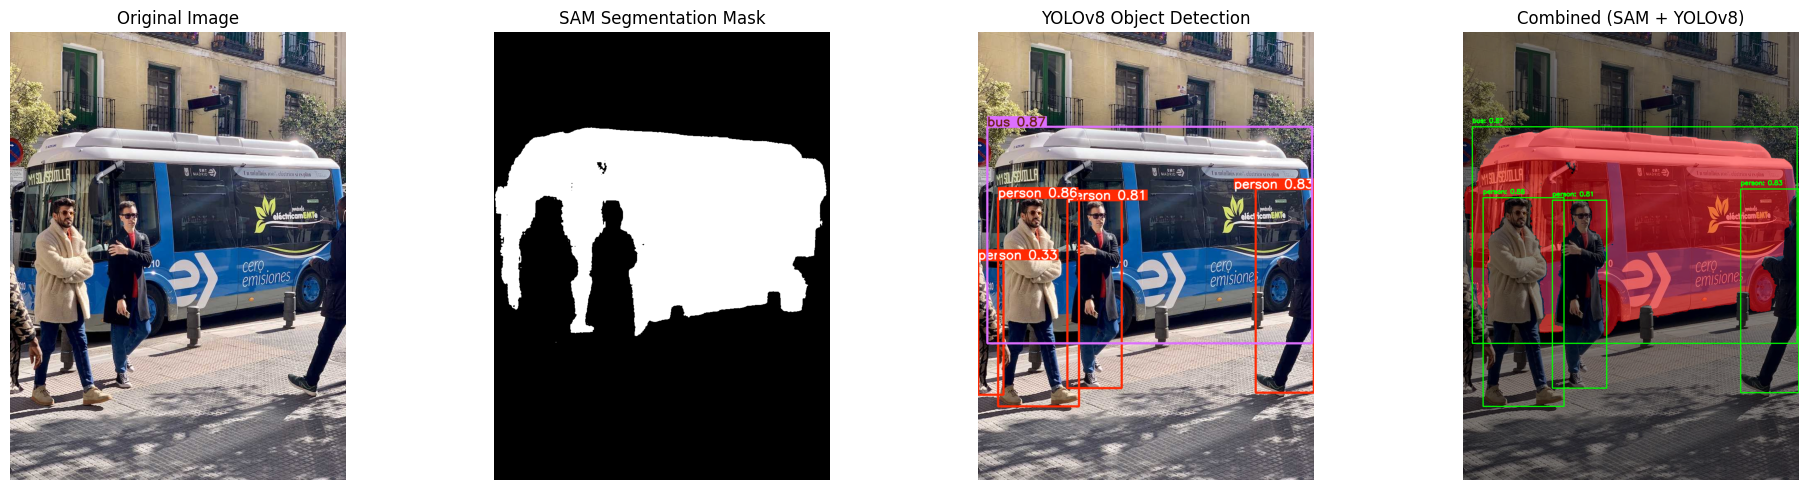

In [ ]:
from ultralytics import YOLO, SAM, ASSETS
import cv2
import numpy as np
import matplotlib.pyplot as plt


sam_model = SAM("sam2_s.pt")
yolo_model = YOLO("yolov8n.pt")

image_path = str(ASSETS / "bus.jpg")
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

yolo_results = yolo_model(original_image)


sam_results = sam_model(image_path, points=[[350, 500]], labels=[1], device="cpu")      # Perform segmentation with SAM

detected_objects = yolo_results[0].boxes.data
detected_objects = detected_objects[detected_objects[:, 4] > 0.5]  # Filter by confidence

mask = sam_results[0].masks.data[0].cpu().numpy()

color_mask = np.zeros_like(original_image)
color_mask[mask > 0] = [255, 0, 0]

alpha = 0.5
blended = cv2.addWeighted(original_image, 1 - alpha, color_mask, alpha, 0)

# Draw bounding boxes for YOLOv8 detections
for det in detected_objects:
    x1, y1, x2, y2, conf, cls = det
    cv2.rectangle(blended, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(blended, f"{yolo_model.names[int(cls)]}: {conf:.2f}", (int(x1), int(y1) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Plotting
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('SAM Segmentation Mask')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(yolo_results[0].plot())
plt.title('YOLOv8 Object Detection')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blended)
plt.title('Combined (SAM + YOLOv8)')
plt.axis('off')

plt.tight_layout()
plt.show()